**import packages**

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import warnings 
warnings.filterwarnings("ignore")
import time

# DATA PREPARATION
## Load the training data and test data

In [2]:
column_name = ['engine_id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
               's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
               's15', 's16', 's17', 's18', 's19', 's20', 's21']
train_FD002 = pd.read_table("./CMAPSSData/train_FD002.txt", header=None, delim_whitespace=True)
train_FD002.columns = column_name
# Test 文件中的cycle数 并不是到死的
test_FD002 = pd.read_table("./CMAPSSData/test_FD002.txt", header=None, delim_whitespace=True)
test_FD002.columns = column_name

# load RUL data 真正的最后循环数存放在这里
RUL_FD002 = pd.read_table("./CMAPSSData/RUL_FD002.txt", header=None, delim_whitespace=True)

In [3]:
train_FD002.head()

,engine_id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21
0,1,1,34.9983,0.8400,100.0,449.44,555.32,1358.61,1137.23,5.48,...,183.06,2387.72,8048.56,9.3461,0.02,334,2223,100.00,14.73,8.8071
1,1,2,41.9982,0.8408,100.0,445.00,549.90,1353.22,1125.78,3.91,...,130.42,2387.66,8072.30,9.3774,0.02,330,2212,100.00,10.41,6.2665
2,1,3,24.9988,0.6218,60.0,462.54,537.31,1256.76,1047.45,7.05,...,164.22,2028.03,7864.87,10.8941,0.02,309,1915,84.93,14.08,8.6723
3,1,4,42.0077,0.8416,100.0,445.00,549.51,1354.03,1126.38,3.91,...,130.72,2387.61,8068.66,9.3528,0.02,329,2212,100.00,10.59,6.4701
4,1,5,25.0005,0.6203,60.0,462.54,537.07,1257.71,1047.93,7.05,...,164.31,2028.00,7861.23,10.8963,0.02,309,1915,84.93,14.13,8.5286


## standard normalization
<span class="mark">train 和 test 集一定都要 正则化，方法就是减去平均值除以方差。
需要注意的是，test集上，正则化用的是training数据的平均值和方差。只能用训练数据集上的信息，test集上的一切信息都不能用。</span>

In [4]:
#### standard normalization ####

# Training 因为前两列是没有用的 engine_id cycle
mean = train_FD002.iloc[:, 2:].mean()
std = train_FD002.iloc[:, 2:].std()
std.replace(0, 1, inplace=True)
train_FD002.iloc[:, 2:] = (train_FD002.iloc[:, 2:] - mean) / std

# Testing
mean = test_FD002.iloc[:, 2:].mean()
std = test_FD002.iloc[:, 2:].std()
std.replace(0, 1, inplace=True)
test_FD002.iloc[:, 2:] = (test_FD002.iloc[:, 2:] - mean) / std

## Compute the RUL

'''
    Piecewise linear function with zero gradient and unit gradient
    
            ^
            |
    MAXLIFE |-----------
            |            \
            |             \
            |              \
            |               \
            |                \
            |----------------------->
    '''
    因为从下图的可视化可以看出，所有的传感器值的变化并不是一个逐渐降低的过程。而是先保持平稳，再出现逐渐变化的趋势。
    也就是说，在刚开始机器的状态并没有开始下滑。而是到一个临界点的时候，才开始下滑。
    那么临界点之前的数据，如果强行默认下滑，可能不好学习。
    临街点的值是通过可视化，凭借经验定义的，大部分都是在倒数120周期的时候开始变化。
<span class="mark">其实可以通过wavelet transformation 降噪，得出变化点的开头，不同数据集。定义不同的临界点！</span>

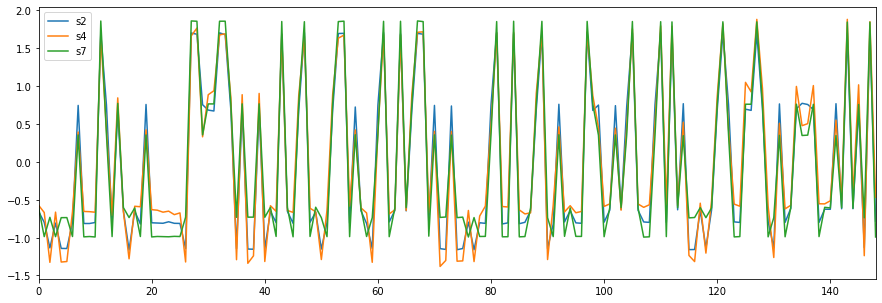

In [5]:
train_FD002[train_FD002["engine_id"]==1][["s2","s4","s7"]].plot(figsize=(15,5));

### Training

In [6]:
id='engine_id'
# 这个是自己定义的， 拐点在120 ，  120之前视为一样
MAXLIFE = 120
rul = [] # 会逐渐装满所有id的RUL
for _id in set(train_FD002[id]):
    trainFD002_of_one_id =  train_FD002[train_FD002[id] == _id]
    cycle_list = trainFD002_of_one_id['cycle'].tolist()
    # 因为这里是run to end ,所以最大cycle数是确定的
    max_cycle = max(cycle_list)
    # 计算出临界点的位置，没到达临界点的时候，全部保存MAXLIFE，到达临界点的时候，逐点下降！
    knee_point = max_cycle - MAXLIFE
    kink_RUL = []
    for i in range(0, len(cycle_list)):
        # 
        if i < knee_point:
            kink_RUL.append(MAXLIFE)
        else:
            tmp = kink_RUL[i - 1] - 1
            kink_RUL.append(tmp)
    # 每跑完一个id就添加到最后总的rul列表中
    rul.extend(kink_RUL)

train_FD002["RUL"] = rul

# training_engine_id = train_FD001['engine_id']
# train_FD001 = train_FD001.drop('engine_id', 1)
# train_FD001 = train_FD001.drop('cycle', 1)

### Testing
TEST数据集和训练数据集是不一样的，RUL是定义好了的。已经读在了RUL_FD001 dataframe里面

In [7]:
id='engine_id'
rul = []
for _id in set(test_FD002[id]):
    # 真实的RUL， 也就是测试数据最后一个周期所对应的RUL
    true_rul = int(RUL_FD002.iloc[_id - 1])
    testFD002_of_one_id =  test_FD002[test_FD002[id] == _id]
    cycle_list = testFD002_of_one_id['cycle'].tolist()
    # 那么总的生命周期数=训练集的已有周期数+最后剩下的周期数
    max_cycle = max(cycle_list) + true_rul
    knee_point = max_cycle - MAXLIFE
    kink_RUL = []
    for i in range(0, len(cycle_list)):
        if i < knee_point:
            kink_RUL.append(MAXLIFE)
        else:
            tmp = kink_RUL[i - 1] - 1
            kink_RUL.append(tmp)    

    rul.extend(kink_RUL)

test_FD002["RUL"] = rul

    训练数据的格式应该是[batch, timesteps, windowsize, numberofsensor] (这里没有考虑channel的维度）
    如果timesteps设置为10，窗口大小设置为24
    那么一个训练集最短至少要有33
    测试集的输入尺寸除了batch,都要保持和训练集的一致
<span class="mark">所以timesteps和窗口大小不能随意定</span>

In [8]:
min_shape = np.min([i[0] for i in train_FD002.groupby("engine_id").apply(np.shape).values])
print("训练集中最小的长度是：",min_shape)

训练集中最小的长度是： 128


In [9]:
min_shape = np.min([i[0] for i in test_FD002.groupby("engine_id").apply(np.shape).values])
print("测试集中最小的长度是：",min_shape)

测试集中最小的长度是： 21


In [10]:
# test_FD001 = test_FD001.drop('engine_id', 1)
# test_FD001 = test_FD001.drop('cycle', 1)
# test_values = test_FD001.values

    这时候 train_FD001 和 test_FD001结构是一样的，第一列是id，中间24个传感器数据，最后一列是 rul

In [11]:
train_FD002[train_FD002["engine_id"]==1].head()

,engine_id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s13,s14,s15,s16,s17,s18,s19,s20,s21,RUL
0,1,1,0.745888,0.864290,0.418183,-0.889370,-0.653065,-0.579171,-0.572616,-0.706170,...,0.415113,-0.212613,0.021948,-0.705927,-0.515574,-0.039953,0.418183,-0.613952,-0.619142,120
1,1,2,1.220542,0.866870,0.418183,-1.057617,-0.798415,-0.630045,-0.668735,-1.140611,...,0.414644,0.067214,0.063718,-0.705927,-0.659695,-0.115644,0.418183,-1.051672,-1.048181,120
2,1,3,0.067835,0.160455,-2.391253,-0.392964,-1.136044,-1.540506,-1.326288,-0.271729,...,-2.393468,-2.377800,2.087778,-0.705927,-1.416328,-2.159298,-2.391253,-0.679813,-0.641906,120
3,1,4,1.221186,0.869451,0.418183,-1.057617,-0.808873,-0.622400,-0.663698,-1.140611,...,0.414254,0.024309,0.030889,-0.705927,-0.695725,-0.115644,0.418183,-1.033433,-1.013798,120
4,1,5,0.067951,0.155617,-2.391253,-0.392964,-1.142480,-1.531540,-1.322259,-0.271729,...,-2.393702,-2.420705,2.090714,-0.705927,-1.416328,-2.159298,-2.391253,-0.674746,-0.666173,120


### Plot a figure

In [12]:
test_FD002.head()

,engine_id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s13,s14,s15,s16,s17,s18,s19,s20,s21,RUL
0,1,1,-0.945701,-1.032013,0.417329,0.609342,0.681281,0.741730,0.856048,0.684631,...,0.418203,0.601954,-0.892999,1.477670,0.758703,0.619508,0.417329,0.765072,0.782424,120
1,1,2,-0.268799,0.414299,0.417329,0.690235,0.756002,0.591040,0.361422,0.361768,...,0.417734,-0.126195,-0.099938,-0.676721,0.578584,0.653935,0.417329,0.348270,0.386904,120
2,1,3,0.746286,0.864463,0.417329,-0.887935,-0.631826,-0.561262,-0.627746,-0.706163,...,0.414841,-0.126434,0.042784,-0.676721,-0.538152,-0.041486,0.417329,-0.591300,-0.604150,120
3,1,4,1.220074,0.867679,0.417329,-1.055769,-0.787963,-0.649864,-0.631694,-1.139406,...,0.414606,0.038903,0.108192,-0.676721,-0.574176,-0.117225,0.417329,-1.058562,-1.023759,120
4,1,5,0.069242,0.161243,-2.396122,-0.392749,-1.148177,-1.560515,-1.280219,-0.272919,...,-2.397767,-2.361697,2.077269,-0.676721,-1.546817,-2.162177,-2.396122,-0.658917,-0.661092,120


training (53759, 24) (53759,)
testing (33991, 24) (33991,)


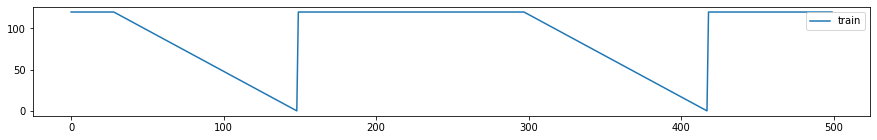

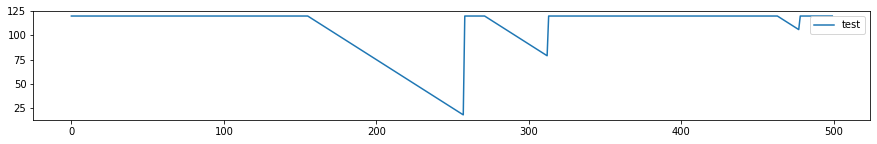

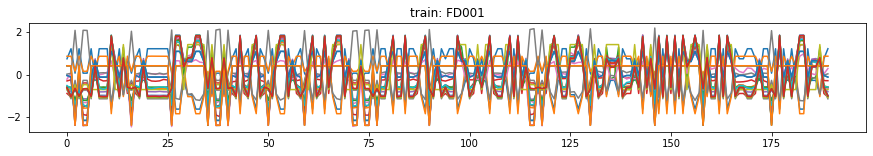

In [13]:
training_data = train_FD002.values
testing_data = test_FD002.values

x_train = training_data[:, 2:-1]
y_train = training_data[:, -1]
print("training", x_train.shape, y_train.shape)

x_test = testing_data[:, 2:-1]
y_test = testing_data[:, -1]
print("testing", x_test.shape, y_test.shape)
# 训练数据集 前面500个数据点所对应的rul 由图中可以看出  都是到零的了
plt.figure(figsize=(15,2))
plt.plot(y_train[:500], label="train")
plt.legend()
plt.figure(figsize=(15,2))
# 测试数据中前500个数据点对应的tul  可以看到结尾数据的rul 都不是中间
plt.plot(y_test[:500], label="test")
plt.legend()
plt.figure(figsize=(15,2))
plt.plot(x_train[:190])
plt.title("train: FD00" + str(1))
# 训练数据第一个id的 24个senor的值 可以通过在x轴坐标100的位置 序列的一些 趋势

plt.show()

# Convolutional NN

In [14]:
def batch_generator(training_data, sequence_length=15, window_size = 15):
    """
    Generator function for creating random batches of training-data for many to many models
    """
    engine_ids = list(training_data["engine_id"].unique())
    temp = training_data.copy()
    # 把 每一段后一截给截掉，获取能够跑的index
    for id_ in engine_ids:
        indexes = temp[temp["engine_id"] == id_].index
        traj_data = temp.loc[indexes]
        # cutoff_cycle 记录下这以后的index就不满足 序列大小的需求的
        cutoff_cycle = max(traj_data['cycle']) - sequence_length - window_size + 1
        
        if cutoff_cycle<0:
            # 也就是步长和窗口大小已经大于了该机器的已有周期数，全部都得扔掉
            drop_range = indexes
            print("有一些数据直接就被抛弃了，请合理设置窗口大小和时间长度")
        else:
            cutoff_cycle_index = traj_data['cycle'][traj_data['cycle'] == cutoff_cycle+2].index
            drop_range = list(range(cutoff_cycle_index[0], indexes[-1] + 1))
            
        temp.drop(drop_range, inplace=True)
    indexes = temp.index
    del temp
    

    x_shape = (len(indexes), sequence_length, window_size, 24)
    x_batch = np.zeros(shape=x_shape, dtype=np.float32)
    y_shape = (len(indexes), sequence_length)
    y_batch = np.zeros(shape=y_shape, dtype=np.float32)
    
    # 第一个数据集
    alt_index = indexes[0]
    for batch_index, index in enumerate(indexes):
        # 因为对齐的原因，都减去了1
        y_batch[batch_index] = training_data.iloc[index+window_size-1:index+window_size-1+sequence_length,-1].values
        
        # 本来应该下面这个 for 循环的，但是考虑到循环的嵌套，跑太久了，而且窗口序列之间又有重复，那么减少循环的次数
        # for seq in range(sequence_length):
            # x_batch[index,seq] = training_data.iloc[idx+seq:idx+seq + window_size, 2:-1].values
        
        if index-alt_index==1 and batch_index!=0:
            temp_window = training_data.iloc[index+sequence_length-1:index+sequence_length-1 + window_size, 2:-1].values.reshape(1,window_size,-1)
            x_batch[batch_index] = np.concatenate((x_batch[batch_index-1][1:],temp_window))
        else:
            for seq in range(sequence_length):
                x_batch[batch_index][seq] = training_data.iloc[index+seq:index+seq + window_size, 2:-1].values
        alt_index = index
    # 如果数据集过于大的情况下 应该使用yield来构成 循环的 generator、
    
    return x_batch, y_batch

# Training CNNLSTM

初始化seed

In [15]:
import tensorflow as tf

In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import TimeDistributed
#from tensorflow.keras.layers.convolutional import Conv3D
#from tensorflow.keras.layers.convolutional_recurrent import ConvLSTM2D
import tensorflow.keras as keras
import tensorflow.keras.layers as layers

In [17]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np

from tensorflow.python.keras import activations
from tensorflow.python.keras import backend as K
from tensorflow.python.keras import constraints
from tensorflow.python.keras import initializers
from tensorflow.python.keras import regularizers
from tensorflow.python.keras.engine.base_layer import Layer
from tensorflow.python.keras.layers.recurrent import DropoutRNNCellMixin
from tensorflow.python.keras.utils import conv_utils
from tensorflow.python.ops import array_ops
from tensorflow.python.util.tf_export import keras_export
from tensorflow.compat.v2.keras.layers import ConvLSTM2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import TimeDistributed
#from tensorflow.keras.layers.convolutional import Conv3D
#from tensorflow.keras.layers.convolutional_recurrent import ConvLSTM2D
import tensorflow.keras as keras
import tensorflow.keras.layers as layers
from tensorflow.python.keras.layers.recurrent import RNN
from tensorflow.python.keras.utils import tf_utils
from tensorflow.python.keras.engine.input_spec import InputSpec
from tensorflow.python.keras.layers.recurrent import _standardize_args
from tensorflow.python.keras.utils import generic_utils

# conv_lstm

In [18]:
x_batch, y_batch =batch_generator(train_FD002,sequence_length=15,window_size = 15)
# 这里需要把输入数据增加一个channel层数
x_batch = np.expand_dims(x_batch, axis=4)
y_batch = np.expand_dims(y_batch, axis=2)

In [19]:
from ConvLSTM2D_2 import ConvLSTM2D_2

In [23]:
sequence_length=15
window_size = 15
kernel_size = 3
model =Sequential()
# input 的shape 应该是 （时间，行-window，列-sensor， channels）
# 参数个数怎么算？？？为啥改变filter个数，参数个数不是按比例增长
# 增加batch ？ 增加 dropout??
model.add(ConvLSTM2D_2(filters=10, kernel_size=(kernel_size, 24),input_shape=(None, window_size, 24, 1), padding='valid', return_sequences=True, dropout=0.4,recurrent_dropout=0.4))
model.add(keras.layers.BatchNormalization())
model.add(ConvLSTM2D_2(filters=10, kernel_size=(kernel_size, 1),padding='valid', return_sequences=True, dropout=0.4,recurrent_dropout=0.4))
model.add(keras.layers.BatchNormalization())
model.add(TimeDistributed(Flatten()))
#model.add(TimeDistributed(Dense(units = 10, activation = "linear")))
model.add(TimeDistributed(Dense(units = 1, activation = "linear")))
model.compile(loss='mse', optimizer='Adam')

In [24]:
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_lst_m2d_2_2 (ConvLSTM2D (None, None, 11, 1, 10)   33340     
_________________________________________________________________
batch_normalization (BatchNo (None, None, 11, 1, 10)   40        
_________________________________________________________________
conv_lst_m2d_2_3 (ConvLSTM2D (None, None, 7, 1, 10)    5140      
_________________________________________________________________
batch_normalization_1 (Batch (None, None, 7, 1, 10)    40        
_________________________________________________________________
time_distributed_3 (TimeDist (None, None, 70)          0         
_________________________________________________________________
time_distributed_4 (TimeDist (None, None, 1)           71        
Total params: 38,631
Trainable params: 38,591
Non-trainable params: 40
_________________________________________________

In [25]:
model.fit(x_batch,y_batch, batch_size=15, epochs=20, validation_split=0.05)

Train on 44155 samples, validate on 2324 samples
Epoch 1/20
  645/44155 [..............................] - ETA: 9:58 - loss: 8668.3088 

KeyboardInterrupt: 

# Evaluation

## Tranining Performance

In [ ]:
y_batch_pred = model.predict(x_batch)

In [ ]:
from sklearn.metrics import mean_squared_error
y_batch_pred = y_batch_pred.reshape(y_batch_pred.shape[0], y_batch_pred.shape[1])
y_batch_reshape = y_batch.reshape(y_batch.shape[0], y_batch.shape[1])
np.sqrt(mean_squared_error(y_batch_pred, y_batch_reshape))

    这个结果有点牛逼，但是有可能是overfitting了，需要在测试集上面验证。

## Test Performance

## Evaluation Method 1
    只验证最后一个值是否正确，也就是Ground Truth文件夹中的值

In [ ]:
def test_batch_generator(test_data, sequence_length=15, window_size = 15):
    """
    这里的seq 和 win size 必须要和前面training的一致
    """
    engine_ids = list(test_data["engine_id"].unique())
    index_list=[]
    temp = test_data.copy()
    for id_ in engine_ids:
        indexes = temp[temp["engine_id"] == id_].index
        traj_data = temp.loc[indexes]
        # 找到对应的index，index以前的数据相当于抛弃了，，这个有待改进
        cutoff_cycle = max(traj_data['cycle']) - sequence_length - window_size + 2
        
        if cutoff_cycle<0:
            # 也就是步长和窗口大小已经大于了该机器的已有周期数，全部都得扔掉
            print("有一些数据直接就被抛弃了，请合理设置窗口大小和时间长度")
        else:
            cutoff_cycle_index = traj_data['cycle'][traj_data['cycle'] == cutoff_cycle].index
            index_list.append(cutoff_cycle_index.values[0])
            

    del temp
    

    x_shape = (len(index_list), sequence_length, window_size, 24)
    x_batch = np.zeros(shape=x_shape, dtype=np.float32)
    y_shape = (len(index_list), sequence_length)
    y_batch = np.zeros(shape=y_shape, dtype=np.float32)
    


    for test_index, index in enumerate(index_list):
        y_batch[test_index] = test_data.iloc[index+window_size-1:index+window_size-1+sequence_length,-1].values
        
        for seq in range(sequence_length):
            x_batch[test_index][seq] = test_data.iloc[index+seq:index+seq + window_size, 2:-1].values
    # 如果数据集过于大的情况下 应该使用yield来构成 循环的 generator、
    
    return x_batch, y_batch

In [ ]:
x_batch, y_batch =  test_batch_generator(test_FD002, sequence_length=15,window_size = 15)
x_batch = np.expand_dims(x_batch, axis=4)

In [ ]:
y_batch_pred = model.predict(x_batch)

In [ ]:
y_batch_pred = y_batch_pred.reshape(y_batch_pred.shape[0],y_batch_pred.shape[1])
y_batch_pred_last_values = [i[-1] for i in y_batch_pred]
y_batch_last_values = [i[-1] for i in y_batch]

In [ ]:
np.sqrt(mean_squared_error(y_batch_pred_last_values, y_batch_last_values))

这里只是RMSE ,还要写其他的 custom metric

In [ ]:
print(y_batch.shape)
y_batch_reshape = y_batch.reshape(y_batch.shape[0],y_batch.shape[1])
print(y_batch.shape)

In [ ]:
y_pre =  model.predict(x_batch)

In [ ]:
print(y_pre.shape)
y_pre_reshape = y_pre.reshape(y_batch.shape[0],y_batch.shape[1])

In [ ]:
np.sqrt(mean_squared_error(y_pre_reshape, y_batch_reshape))

# Save Model

In [ ]:
#model.save('D:/master_arbeit/model_F02_22_23.h5')